### How big is my DataFrame?
`df.info()` , `df.memory_usage()`

### NumPy transformations
- Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.
- The function memory_footprint() has been provided to return the total amount of memory (in megabytes or MB) currently in use by our program. This function uses the psutil and os modules.

In [20]:
import numpy as np
from dask import delayed
import psutil, os
import matplotlib.pyplot as plt
# from glob import glob
import glob
import pandas as pd
import time
import dask.dataframe as dd

def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 **2)

In [7]:
N = (1024 **2) //8 # number of floats that fill 1 MB
celsius = np.random.randn(50 * N) # Random array filling 50MB

# Print the size in MB of the celsius array
print(celsius.nbytes / 1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius * 9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)

50.0
50.00390625


### Computing percentage of delayed flights
- build a function to compute the percentage of delayed flights given a DataFrame of flight information. 


In [8]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY'] > 0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)


### Generating & plotting delayed flights

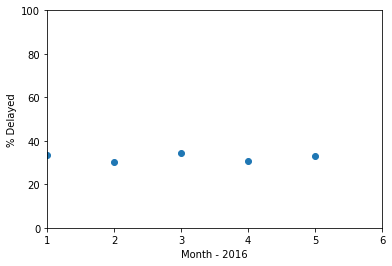

In [9]:
# Define the generator: dataframes
filenames = glob.glob('../data/flightdelays/*.csv')
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

# Create the plot
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,6))
plt.ylim((0,100))
plt.show()

### Building a pipeline with delayed
- If we use `dask.delayed`, we don't need to use generators; the dask scheduler will manage memory usage.
- **Task** : define three decorated functions to complete the pipeline: a function to total the number of flights, a function to count the number of delayed flights, and a function to aggregate the results.

In [10]:
from dask import delayed
import os 
import glob
import pandas as pd

In [11]:
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

- These functions constitute the pieces of the pipeline for our flight-delay analysis

### Computing pipelined results
- Now that the dask.delayed functions are defined, we can use them to construct the pipeline of delayed tasks.
-  loop over the file names, store the temporary information in lists, and aggregate the final result.
- The distinction here is that we are working with `dask.delayed` functions and objects, not real, computed values. The computation will only be executed when we call `.compute()` on the final result.

In [12]:
filenames = glob.glob('../data/flightdelays/*.csv')
filenames

['../data/flightdelays\\flightdelays-2016-1.csv',
 '../data/flightdelays\\flightdelays-2016-2.csv',
 '../data/flightdelays\\flightdelays-2016-3.csv',
 '../data/flightdelays\\flightdelays-2016-4.csv',
 '../data/flightdelays\\flightdelays-2016-5.csv']

In [13]:
n_delayed = []
n_flights = []
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = pd.read_csv(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824


- Notice that no reading and no computation was done until the last line (result.compute()). In all the preceding lines, the functions called returned dask.delayed objects that deferred execution until the invocation of compute().

### Subtracting & broadcasting
- The one-dimensional array load_2001 holds the total electricity load for the state of Texas sampled every 15 minutes for the entire year 2001 (35040 samples in total). The one-dimensional array load_recent holds the corresponding data sampled for each of the years 2013 through 2015 (i.e., 105120 samples consisting of the samples from 2013, 2014, & 2015 in sequence). None of these years are leap years, so each year has 365 days. Observe also that there are 96 intervals of duration 15 minutes in each day.
- compute the differences of the samples in the years 2013 to 2015 each from the corresponding samples of 2001.

In [14]:
import numpy as np
import h5py

hf = h5py.File('../data/Texas/texas.2001.hdf5', 'r')
print('dataset name:', hf.keys())
load_2001 = np.array(hf["load"][:]) #dataset_name is same as hdf5 object name 
load_2001.shape

dataset name: <KeysViewHDF5 ['load']>


(35040,)

In [15]:
hf = h5py.File('../data/Texas/texas.2013.hdf5', 'r')
hf_14 = h5py.File('../data/Texas/texas.2014.hdf5', 'r')
hf_15 = h5py.File('../data/Texas/texas.2015.hdf5', 'r')
print('dataset name:', hf.keys())
load_2013 = np.array(hf["load"][:]) #dataset_name is same as hdf5 object name 
load_2014 = np.array(hf_14["load"][:])
load_2015 = np.array(hf_15["load"][:])
load_recent = np.hstack([load_2013,load_2014,load_2015])
load_recent.shape

dataset name: <KeysViewHDF5 ['load']>


(105120,)

In [16]:
# Reshape load_recent to three dimensions: load_recent_3d
load_recent_3d = load_recent.reshape((3,365,96))

# Reshape load_2001 to three dimensions: load_2001_3d
load_2001_3d = load_2001.reshape((1,365,96))

# Subtract the load in 2001 from the load in 2013 - 2015: diff_3d
diff_3d = load_recent_3d - load_2001_3d

# Print the difference each year on March 2 at noon
print(diff_3d[:, 61, 48])

[-1153.309    22.598   -17.925]


### Computing aggregations
- compute summary statistics by aggregating NumPy arrays across various dimensions (in this case, giving trends in electricity usage).
- `load_recent_3d` contains the electricity load (in kWh) sampled every 15 minutes from the start of 2013 to the end of 2015. The possible index values of the three-dimensional array correspond to year (from 0 to 2), day (from 0 to 364), and 15-minute interval (from 0 to 95); remember, NumPy arrays are indexed from zero. Thus, load_recent_3d[0,1,2] is the electricity load consumed on January 2nd, 2013 from 00:30:00 AM to 00:45:00 AM.


In [17]:
# Print mean value of load_recent_3d
print(load_recent_3d.mean())

# Print maximum of load_recent_3d across 2nd & 3rd dimensions
print(load_recent_3d.max(axis=(1,2)))

# Compute sum along last dimension of load_recent_3d: daily_consumption
daily_consumption = load_recent_3d.sum(axis=-1)

# Print mean of 62nd row of daily_consumption
print(daily_consumption[:,61].mean())

5240.84666194825
[6335.42  6336.159 6344.077]
470184.43899999995


### Inspecting a large DataFrame

### Building a pipeline of delayed tasks
- filter the DataFrame for the 'East Asia & Pacific' region and measurements of the percent population exposed to toxic air pollution. The output of this effort is a delayed Dask DataFrame

In [21]:
# Read from 'WDI.csv': df
import dask.dataframe as dd

df = dd.read_csv('../data/WDI/WDI.csv')

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'AG.PRD.LVSK.XD'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df.loc[toxins & region]
print(filtered.shape)

(Delayed('int-452810a7-d4ca-463f-bc84-8952051466c4'), 7)


### Grouping & aggregating by year
-  plot the average percent of the population exposed to air pollution in the East Asia & Pacific region from 2010 to 2015.
- use .groupby() to collect all of the individual country values by the 'Year' column and aggregate with the mean() function. Then call .compute() to perform the computation in parallel, and finally plot the results.

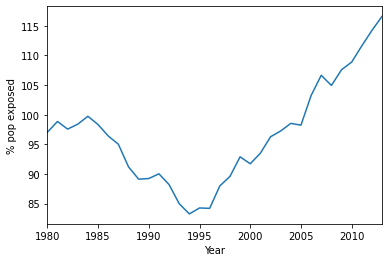

In [22]:
# Grouby filtered by the 'Year' column: yearly
yearly = filtered.groupby('Year')

# Calculate the mean of yearly: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean.compute()

# Plot the 'value' column with .plot.line()
result['value'].plot.line()
plt.ylabel('% pop exposed')
plt.show()

### Preparing the pipeline

In [23]:
# Define a function with df as input: by_region
def by_region(df):

    # Create the toxins array
    toxins = df['Indicator Code'] == 'AG.PRD.LVSK.XD'

    # Create the y2015 array
    y2015 = df['Year'] == 2015

    # Filter the DataFrame and group by the 'Region' column
    regions = df[toxins & y2015].groupby('Region')

    # Return the mean of the 'value' column of regions
    return regions['value'].mean()


#### Comparing Dask & pandas execution times
- The function can be used with either Dask or Pandas DataFrames. The only difference is that after the function is run on a Dask DataFrame, .compute() must be called on the result to perform the computation.

In [25]:
# Call time.time()
import time 

t0 = time.time()

# Read 'WDI.csv' into df
df = pd.read_csv('../data/WDI/WDI.csv')

# Group df by region: result
result = df.groupby('Region')

r = by_region(df)

# Call time.time()
t1 = time.time()

# Print the execution time
print((t1-t0)*1000)

207.08274841308594


In [27]:
# Time the execution of just by_region with Pandas and print in milliseconds
df = pd.read_csv('../data/WDI/WDI.csv')
t0 = time.time()
result = by_region(df)
t1 = time.time()
print((t1-t0)*1000)

11.494159698486328


In [29]:
# Time the execution of dd.read_csv and by_region together with 'WDI.csv' and print in milliseconds
t0 = time.time()
df = dd.read_csv('../data/WDI/WDI.csv')
result = by_region(df)
t1 = time.time()
print((t1-t0)*1000)

36.011695861816406


##### Conclusion : We can see that if the data set can be read into memory with `pandas` it is likely going to be faster than `Dask`, which needs to `read the file chunkwise throughout the pipeline` and does not cache intermediates in memory.

## Reading & cleaning files using Dask


In [2]:
import dask.dataframe as dd

# Read all .csv files: df
df = dd.read_csv('../data/nyctaxi/*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df.tpep_dropoff_datetime.dt.hour

C:\Users\Shubham\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Filtering & grouping data
- task now is to `build a pipeline of computations` to compute the hourly average tip fraction for each hour of the day across the entire year of data. We'll have to filter for payments of type 1 (credit card transactions) from the 'payment_type' column, group transactions using the 'hour' column, and finally aggregate the mean from the 'tip_fraction' column.

In [3]:
# Filter rows where payment_type == 1: credit
credit = df[df['payment_type'] == 1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

<class 'dask.dataframe.core.Series'>


### Computing & plotting
- Now that we've got the entire delayed pipeline prepared it's time to `compute` and plot the result.

<class 'pandas.core.series.Series'>


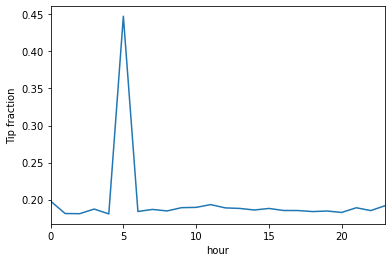

In [4]:
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

##  Dask Bags
### Reading & counting

In [4]:
import dask.bag as db

# Glob filenames matching 'sotu/*.txt' and sort
filenames = glob.glob('../data/sotu/*.txt')
filenames = sorted(filenames)

# Load filenames as Dask bag with db.read_text(): speeches
speeches = db.read_text(filenames)

# Print number of speeches with .count()
print(speeches.count().compute())

237


- For large datasets, the `.take()` method is useful for inspecting data & data types while processing dask bags. The value returned by `.take(n)` is a tuple of the first n elements of the dask.bag.

In [8]:
# Call .take(1): one_element
one_element = speeches.take(1)
print('one element type:', type(one_element))

# Extract first element of one_element: first_speech
first_speech = one_element[0]

# Print type of first_speech and first 60 characters
print(type(first_speech))
print(first_speech[:60])

one element type: <class 'tuple'>
<class 'str'>
 Fellow-Citizens of the Senate and House of Representatives:


### Splitting by word & count

In [9]:
# Call .str.split(' ') from speeches and assign it to by_word
by_word = speeches.str.split(' ')

# Map the len function over by_word and compute its mean
n_words = by_word.map(len)
avg_words = n_words.mean()

# Print the type of avg_words and value of avg_words.compute()
print(type(avg_words))
print(avg_words.compute())


<class 'dask.bag.core.Item'>
8239.084388185654


### Filtering on a phrase

In [10]:
# Convert speeches to lower case: lower
lower = speeches.str.lower()

# Filter lower for the presence of 'health care': health
health = lower.filter(lambda s:'health care' in s)

# Count the number of entries : n_health
n_health = health.count()

# Compute and print the value of n_health
print(n_health.compute())

47


### Delaying reading & cleaning
- To work with this subset of the monthly flight information data efficiently, we'll need to do a bit of cleaning. Specifically, we'll need to replace zeros in the `'WEATHER_DELAY'` column with `nan`. This substitution will make counting delays much easier later. This operation requires us to build a delayed pipeline of pandas DataFrame manipulations
- convert the output to a Dask DataFrame in which each file will be one chunk.

In [7]:
# Define @delayed-function read_flights
@delayed
def read_flights(filename):

    # Read in the DataFrame: df
    df = pd.read_csv(filename, parse_dates=['FL_DATE'])

    # Replace 0s in df['WEATHER_DELAY'] with np.nan
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0, np.nan)

    # Return df
    return df

##### function read_flights returns a delayed object that corresponds to reading a DataFrame from disk and cleaning some of its entries.

### Reading all flight data
- task now is to iterate over the files and to use the function `read_flights` to build a list of delayed objects. 
- **concatenate them into a `Dask DataFrame` with `dd.from_delayed()`** and print out the mean of the `WEATHER_DELAY` column.

In [12]:
filenames = glob.glob('../data/flightdelays/*.csv')
dataframes = []
# Loop over filenames with index filename
for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
print(flight_delays['WEATHER_DELAY'].mean().compute())

51.29467680608365


### Preparing weather data

#### Deferring reading weather data
- The ultimate goal is to correlate the flight delays with weather events from each day of 2016.

In [13]:
# Define @delayed-function read_weather with input filename
@delayed
def read_weather(filename):
    # Read in filename: df
    df = pd.read_csv(filename, parse_dates=['Date'])

    # Clean 'PrecipitationIn'
    df['PrecipitationIn'] = pd.to_numeric(df['PrecipitationIn'], errors='coerce')

    # Create the 'Airport' column
    df['Airport'] = filename.split('.')[0]

    # Return df
    return df

##### The function read_weather returns a delayed object that yields a Pandas DataFrame when executed.

### Building a weather DataFrame

In [17]:
weather_dfs = []
filenames = glob.glob('../data/weatherdata/*.csv')
filenames = [file for file in filenames if '2016' not in file]                      

# Loop over filenames with filename
for filename in filenames:
    # Invoke read_weather on filename; append result to weather_dfs
    weather_dfs.append(read_weather(filename))

# Call dd.from_delayed() with weather_dfs: weather
weather = dd.from_delayed(weather_dfs)

# Print result of weather.nlargest(1, 'Max TemperatureF')
print(weather.nlargest(1, 'Max TemperatureF').compute())

          Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
224 2016-08-12               107                 93                79   

     Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
224              75              71             66            79   

     Mean Humidity  Min Humidity  ...  Mean VisibilityMiles  \
224             53            27  ...                     8   

     Min VisibilityMiles  Max Wind SpeedMPH  Mean Wind SpeedMPH  \
224                    0                 41                  10   

     Max Gust SpeedMPH  PrecipitationIn  CloudCover             Events  \
224               54.0             0.82           5  Rain-Thunderstorm   

     WindDirDegrees  Airport  
224             214           

[1 rows x 24 columns]


### Which city gets the most snow?
- aggregate the total snow fall for each airport (at least those airports that experienced snow).

In [18]:
# Make cleaned Boolean Series from weather['Events']: is_snowy
is_snowy = weather['Events'].str.contains('Snow').fillna(False)

# Create filtered DataFrame with weather.loc & is_snowy: got_snow
got_snow = weather.loc[is_snowy]

# Groupby 'Airport' column; select 'PrecipitationIn'; aggregate sum(): result
result = got_snow.groupby('Airport')['PrecipitationIn'].sum()

# Compute & print the value of result
print(result.compute())

Airport
    11.44
Name: PrecipitationIn, dtype: float64


### Merge flight_delays and weather

In [31]:
weather_delays = flight_delays.merge(weather, left_on=['FL_DATE'], right_on=['Date'], how='inner')
weather_delays = weather_delays[['FL_DATE','ORIGIN','WEATHER_DELAY','Date','Events','Airport']]

### Persisting merged DataFrame
- If our data can fit into memory, either on a workstation or a cluster, persisting the Dask DataFrame with the `.persist()` method can be useful. In particular, persisting DataFrames can provide significant speed-up because the time-consuming work of reading from disk is performed only once.

In [34]:
def percent_delayed(df):
    return (df['WEATHER_DELAY'].count() / len(df)) * 100

# Print time in milliseconds to compute percent_delayed on weather_delays
t_start = time.time()
print(percent_delayed(weather_delays).compute())
t_end = time.time()
print('time->',(t_end-t_start)*1000)

# Call weather_delays.persist(): persisted_weather_delays
persisted_weather_delays = weather_delays.persist()

# Print time in milliseconds to compute percent_delayed on persisted_weather_delays
t_start = time.time()
print(percent_delayed(persisted_weather_delays).compute())
t_end = time.time()
print('time->',(t_end-t_start)*1000)

0.8039985937667181
time-> 20664.28232192993
0.8039985937667181
time-> 20.10512351989746


##### the computed percentage of flights was the same in both trials (about 1.45%), but that the execution time was less in the second attempt. This improvement is a result of persisting the DataFrame as expected.

### Finding sources of weather delays
- use the persisted_weather_delays Dask DataFrame to determine the percentage of delayed flights per weather event.
- compute the number of delayed flights by weather events and divide by the total number of flights. We'll then use `.nlargest(5)` to retrieve the five highest contributions to the number of delayed flights. Finally, we'll compute the average length of the delay for the 5 leading contributions.

In [35]:
# Group persisted_weather_delays by 'Events': by_event
by_event = persisted_weather_delays.groupby('Events')

# Count 'by_event['WEATHER_DELAY'] column & divide by total number of delayed flights
pct_delayed = by_event['WEATHER_DELAY'].count() / persisted_weather_delays['WEATHER_DELAY'].count() * 100

# Compute & print five largest values of pct_delayed
print(pct_delayed.nlargest(5).compute())

# Calculate mean of by_event['WEATHER_DELAY'] column & return the 5 largest entries: avg_delay_time
avg_delay_time = by_event['WEATHER_DELAY'].mean().nlargest(5)

# Compute & print avg_delay_time
print(avg_delay_time.compute())

Events
Rain-Thunderstorm    16.838675
Rain                 15.279739
Snow                  6.941879
Fog-Snow              2.330255
Rain-Snow             1.966323
Name: WEATHER_DELAY, dtype: float64
Events
Fog-Rain-Thunderstorm    60.375000
Thunderstorm             60.155738
Fog                      56.908000
Fog-Rain                 55.342593
Fog-Snow                 53.533800
Name: WEATHER_DELAY, dtype: float64
